# Miscellaneous proofs

## fit unresolved multi-components line when components velocity is known

In [1]:
import numpy as np
import pylab as pl
import orb.sim
import orb.core
import orb.utils.spectrum

R= 1760.572134149879
R= 7043.531585882276
velocity of the lines (should be near 0) [0.13(13) 0.13(13) 0.13(13)]
flux of the lines (should be the same) [1.0071(12) 1.00116(89) 1.0093(12)]


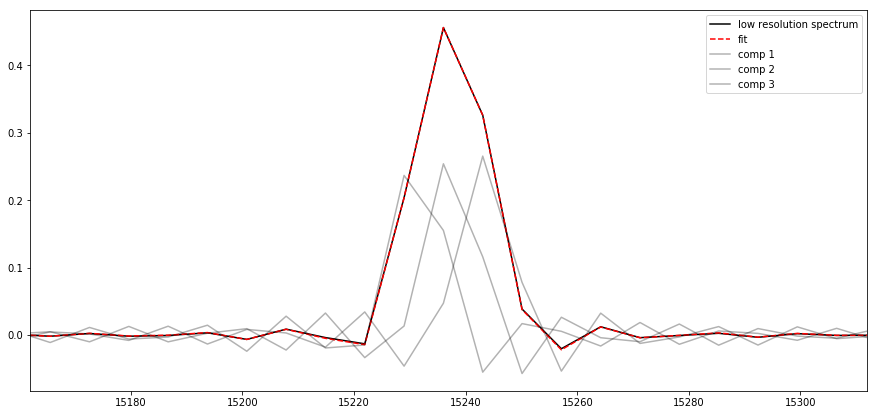

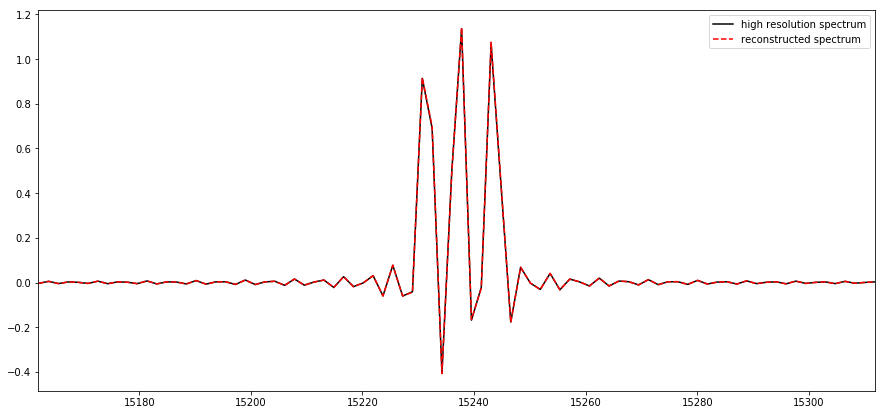

In [4]:
VEL = 120
PLOT_LIM = 75
LOW_R = 250
HIGH_R = 1000

def simulate(step_nb):
    sim = orb.sim.Simulator(step_nb, 'SN3')
    sim.add_line('Halpha', flux=1)
    sim.add_line('Halpha', vel=-VEL)
    sim.add_line('Halpha', vel=+VEL)
    spec = sim.get_interferogram().get_spectrum()
    spec.data.imag.fill(0) # to avoid fitting the imaginary part also 
    print 'R=', orb.utils.spectrum.compute_resolution(spec.dimx, spec.params.step, spec.params.order, spec.params.calib_coeff)
    return spec

spec_low = simulate(LOW_R)
spec_high = simulate(HIGH_R)

pl.figure(figsize=(15,7))
pl.plot(spec_low.axis.data, spec_low.data, c='black', label='low resolution spectrum')
pl.xlim((1e7/656.3-PLOT_LIM, 1e7/656.3+PLOT_LIM))

ha_cm1 = orb.core.Lines().get_line_cm1('Halpha')
lines = [ha_cm1 + orb.utils.spectrum.line_shift(-VEL, ha_cm1),
         ha_cm1,
         ha_cm1 + orb.utils.spectrum.line_shift(VEL, ha_cm1)]

fit = spec_low.fit(lines, pos_def='1', fmodel='sinc')

print 'velocity of the lines (should be near 0)', fit['velocity_gvar']
print 'flux of the lines (should be the same)', fit['flux_gvar']

# high resolution reconstruction from low resolution fit
sim = orb.sim.Simulator(HIGH_R, 'SN3')
sim.add_line(lines[0] + orb.utils.spectrum.line_shift(fit['velocity'][0], lines[0]), flux=fit['flux'][0])
sim.add_line(lines[1] + orb.utils.spectrum.line_shift(fit['velocity'][1], lines[1]), flux=fit['flux'][1])
sim.add_line(lines[2] + orb.utils.spectrum.line_shift(fit['velocity'][2], lines[2]), flux=fit['flux'][2])
rec_spec = sim.get_interferogram().get_spectrum()

# plot the sum of all components
pl.plot(spec_low.axis.data, fit['fitted_vector'], ls='--', c='red', label='fit')

# plot all components
i = 1
for imod in fit['fitted_models']['Cm1LinesModel']:
    pl.plot(spec_low.axis.data, imod, c='black', alpha=0.3, label='comp {}'.format(i))
    i += 1
    
pl.legend()

pl.figure(figsize=(15, 7))
pl.plot(spec_high.axis.data, spec_high.data, c='black', label='high resolution spectrum')
pl.plot(rec_spec.axis.data, rec_spec.data, ls='--', c='red', label='reconstructed spectrum')
pl.xlim((1e7/656.3-PLOT_LIM, 1e7/656.3+PLOT_LIM))
pl.legend()

# What happens with ME loss at high OPD ?

ME loss can be understood as apodization. Line flux is not modified, continuum amplitude is not modified. Only the ILS (line shape) is changed.

Here a gaussian loss is simulated because it corresponds to a `sincgauss` model which can be fitted. More complicated ME loss can produce strange ILS which cannot be fitted with an analytical model.

In any case :  **FLUX is conserved with ME loss (but not SNR, less photons is less photons)**

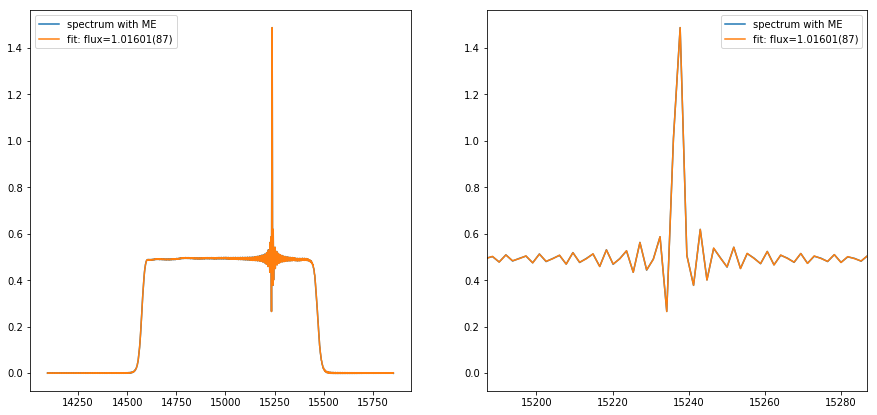

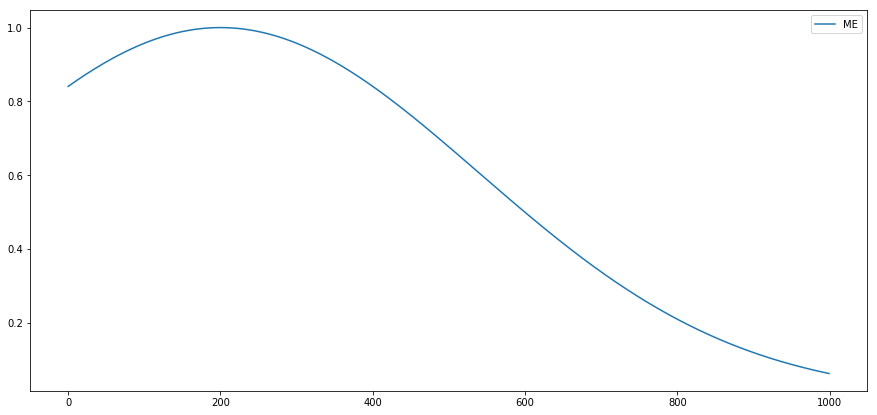

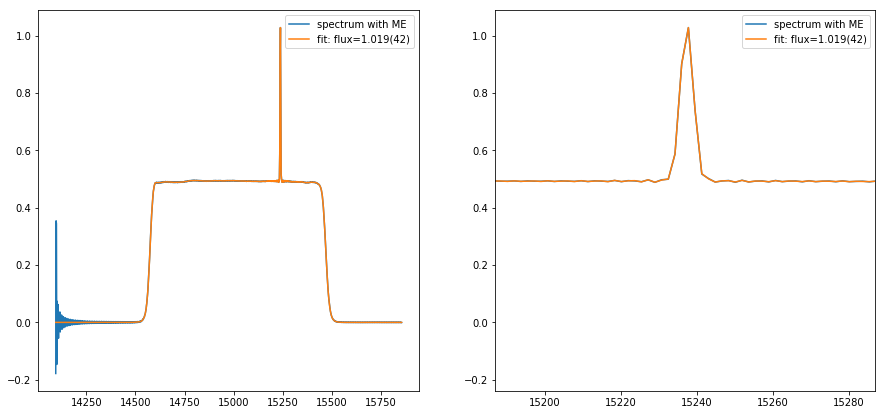

In [3]:
PLOT_LIM = 50
sim = orb.sim.Simulator(1000, 'SN3')
sim.add_line('Halpha', flux=1)
sim.add_background()
interf = sim.get_interferogram()
interf_me = interf.copy()

spec = interf.get_spectrum()
spec.data.imag.fill(0.)
fit = spec.fit(['Halpha'], fmodel='sinc', nofilter=False)

fig, axes = pl.subplots(ncols=2, figsize=(15, 7))
axes[0].plot(spec.axis.data, spec.data, label='spectrum with ME')
axes[0].plot(spec.axis.data, fit['fitted_vector'], label='fit: flux={}'.format(fit['flux_gvar'][0]))
axes[0].legend()
axes[1].plot(spec.axis.data, spec.data, label='spectrum with ME')
axes[1].plot(spec.axis.data, fit['fitted_vector'], label='fit: flux={}'.format(fit['flux_gvar'][0]))
axes[1].set_xlim((1e7/656.3-PLOT_LIM, 1e7/656.3+PLOT_LIM))
axes[1].legend()

# add ME
me = orb.utils.spectrum.gaussian1d(interf.axis.data, 0, 1, 0, interf.axis.data[-1]*1)

pl.figure(figsize=(15, 7))
pl.plot(me, label='ME')
pl.legend()

interf_me.data *= me

spec_me = interf_me.get_spectrum()
spec_me.data.imag.fill(0.)
fit_me = spec_me.fit(['Halpha'], fmodel='sincgauss', nofilter=False, sigma_guess=30)

fig, axes = pl.subplots(ncols=2, figsize=(15, 7))
axes[0].plot(spec_me.axis.data, spec_me.data, label='spectrum with ME')
axes[0].plot(spec_me.axis.data, fit_me['fitted_vector'], label='fit: flux={}'.format(fit_me['flux_gvar'][0]))
axes[0].legend()
axes[1].plot(spec_me.axis.data, spec_me.data, label='spectrum with ME')
axes[1].plot(spec_me.axis.data, fit_me['fitted_vector'], label='fit: flux={}'.format(fit_me['flux_gvar'][0]))
axes[1].set_xlim((1e7/656.3-PLOT_LIM, 1e7/656.3+PLOT_LIM))
axes[1].legend()